# Real-time fMRI data quality checking with Python

By Stephan Heunis

## What is this?


Currently, this is just a playground for you to test out the code and try out your own tweaks. The goal is to build an open educational notebook for learning about real-time fMRI processing methods and quality control in a hands-on way. Please contribute!


## Usage

To be populated

## Some measures

Framewise displacement:

$$
F D_{i}=\left|\Delta d_{i x}\right|+\left|\Delta d_{i y}\right|+\left|\Delta d_{i z}\right|+\left|\Delta a_{i}\right|+\left|\Delta \beta_{i}\right|+\left|\Delta_{\gamma i}\right|
$$

$$
\Delta d_{i x}=d_{(i-1) x}-d_{i x}
$$

$$
\left[d_{i x}  d_{i y}  d_{i z}  \alpha_{i}  \beta_{i}  \gamma_{i}\right]
$$

## Import required Python packages

In [12]:
import os
import nibabel as nib
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from niwidgets import NiftiWidget
from nipy.algorithms.registration import HistogramRegistration, Rigid, resample
from nipy.io.api import save_image
from IPython.display import display, clear_output, HTML
from nilearn import plotting, image
from time import sleep
from scripts import *
import warnings; warnings.simplefilter('ignore')

## Load and manipulate data, define variables

In [13]:
rs_fn = '/Users/jheunis/Documents/PYTHON/sandbox/ds000256-download/sub-CTS200/func/sub-CTS200_task-restbaseline_bold.nii.gz'
func_img = nib.load(rs_fn)
func_data = func_img.get_fdata()

template_fn = 'template_func.nii.gz'
template_img = nib.nifti1.Nifti1Image(func_data[:,:,:,0], func_img.affine, func_img.header)
nib.save(template_img, template_fn)
niiRefVol = template_img

ts = np.arange(func_img.header['dim'][4])
slc = 20
ccoords = [-5, -20, 40]

## Run online code to visualise output in real-time

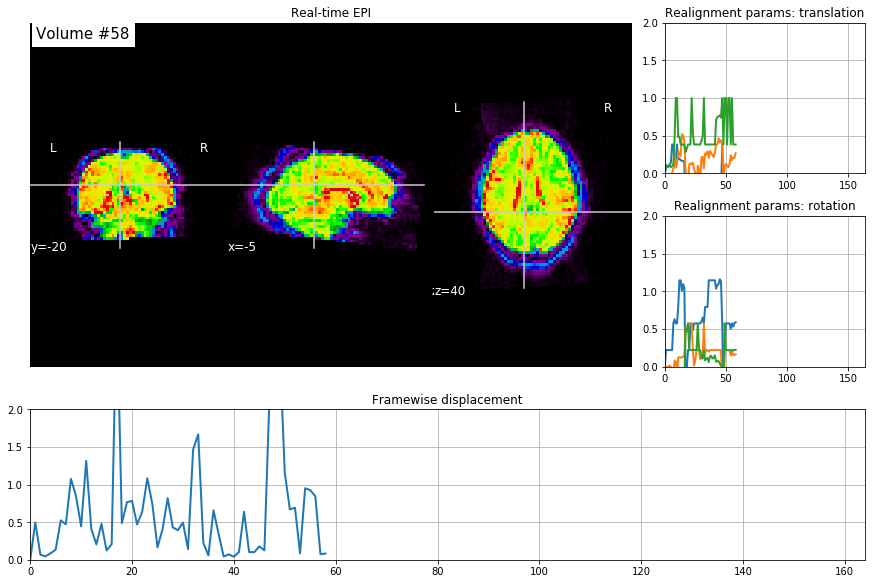

In [ ]:
fig3 = plt.figure(figsize=(12,8), constrained_layout=True)
gs = fig3.add_gridspec(3, 4)
f3_ax1 = fig3.add_subplot(gs[0:2, 0:3])
f3_ax1.set_title('Real-time EPI')

f3_ax2 = fig3.add_subplot(gs[0, 3], xlim=(0, func_img.header['dim'][4]), ylim=(0, 2))
f3_ax2.set_title('Realignment params: translation')

f3_ax3 = fig3.add_subplot(gs[1, 3], xlim=(0, func_img.header['dim'][4]), ylim=(0, 2))
f3_ax3.set_title('Realignment params: rotation')

f3_ax4 = fig3.add_subplot(gs[2, :], xlim=(0, func_img.header['dim'][4]), ylim=(0, 2))
f3_ax4.set_title('Framewise displacement')

# f3_ax5 = fig3.add_subplot(gs[3, :])
# f3_ax5.set_title('ax5')

framew_disp = np.full(ts.shape, np.nan)
realignment_params = np.full((func_img.header['dim'][4], 6), np.nan)
line2x, = f3_ax2.plot(ts, realignment_params[:,0], lw=2)
line2y, = f3_ax2.plot(ts, realignment_params[:,1], lw=2)
line2z, = f3_ax2.plot(ts, realignment_params[:,2], lw=2)
line2xrad, = f3_ax3.plot(ts, realignment_params[:,3], lw=2)
line2yrad, = f3_ax3.plot(ts, realignment_params[:,4], lw=2)
line2zrad, = f3_ax3.plot(ts, realignment_params[:,5], lw=2)
line3, = f3_ax4.plot(ts, framew_disp, lw=2)
f3_ax2.grid()
f3_ax3.grid()
f3_ax4.grid()
display(fig3)
plotting.plot_epi(epi_img=niiRefVol, axes=f3_ax1, cut_coords=ccoords, title='Volume #{}'.format(0) )

for i in ts:
    niiVol = nib.nifti1.Nifti1Image(func_data[:,:,:,i], func_img.affine, func_img.header)
    realignment_params[i,:], realignedVolume = estimateMotion(niiRefVol, niiVol, 'powell')
    
    if i==0:
        framew_disp[i] = 0
    else:
        framew_disp[i] = np.sum(np.abs(realignment_params[i]-realignment_params[i-1]))
        
    # visualize the results
    plotting.plot_epi(epi_img=niiVol, axes=f3_ax1, cut_coords=ccoords, title='Volume #{}'.format(i) )
    line3.set_ydata(framew_disp)
    line2x.set_ydata(realignment_params[:, 0])
    line2y.set_ydata(realignment_params[:, 1])
    line2z.set_ydata(realignment_params[:, 2])
    line2xrad.set_ydata(realignment_params[:, 3])
    line2yrad.set_ydata(realignment_params[:, 4])
    line2zrad.set_ydata(realignment_params[:, 5])
    clear_output(wait = True)
    display(fig3)